### Tentative Plan

• Figure out how to get larger file (objects.csv) to github <br>
• Decide on how to break down categorical variables <br> 
    • Convert categorical variables to dummy variables <br>
• Linear regression for valuation <br>
• Test for hidden counfounders? <br>
• Refit without large p-values or fit lasso regression for better model <br>
• Create labels for companies based on valuation size <br>
• Use logistic regression to classify based on labels <br>
• Decide on which funding series to use for funding amounts  https://support.crunchbase.com/hc/en-us/articles/115010458467-Glossary-of-Funding-Types<br>
• Split data into different models for each series <br>
• Run regression to see what factors are most important for funding amount at each series

### Imports

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
from scipy.stats import mode

### Loading data

In [4]:
#accessing data via github
url1 = "https://raw.githubusercontent.com/kirkhach/startup-ecosystem-analysis/main/data/acquisitions.csv"
download1 = requests.get(url1).content
url2 = "https://raw.githubusercontent.com/kirkhach/startup-ecosystem-analysis/main/data/degrees.csv"
download2 = requests.get(url2).content
url3 = "https://raw.githubusercontent.com/kirkhach/startup-ecosystem-analysis/main/data/funding_rounds.csv"
download3 = requests.get(url3).content
url4 = "https://raw.githubusercontent.com/kirkhach/startup-ecosystem-analysis/main/data/funds.csv"
download4 = requests.get(url4).content
url5 = "https://raw.githubusercontent.com/kirkhach/startup-ecosystem-analysis/main/data/investments.csv"
download5 = requests.get(url5).content
url6 = "https://raw.githubusercontent.com/kirkhach/startup-ecosystem-analysis/main/data/ipos.csv"
download6 = requests.get(url6).content
url7 = "https://raw.githubusercontent.com/kirkhach/startup-ecosystem-analysis/main/data/offices.csv"
download7 = requests.get(url7).content
url8 = "https://raw.githubusercontent.com/kirkhach/startup-ecosystem-analysis/main/data/people.csv"
download8 = requests.get(url8).content
url9 = "https://raw.githubusercontent.com/kirkhach/startup-ecosystem-analysis/main/data/relationships.csv"
download9 = requests.get(url9).content

#load in the data
acqs = pd.read_csv(io.StringIO(download1.decode('utf-8')))
degs = pd.read_csv(io.StringIO(download2.decode('utf-8')))
rounds = pd.read_csv(io.StringIO(download3.decode('utf-8')))
funds = pd.read_csv(io.StringIO(download4.decode('utf-8')))
invs = pd.read_csv(io.StringIO(download5.decode('utf-8')))
ipos = pd.read_csv(io.StringIO(download6.decode('utf-8')))
ofcs = pd.read_csv(io.StringIO(download7.decode('utf-8')))
ppl = pd.read_csv(io.StringIO(download8.decode('utf-8')))
relns = pd.read_csv(io.StringIO(download9.decode('utf-8')))


#too large for github....may need to use git lfs
objs = pd.read_csv('/Users/kirk.hachigian/Desktop/21SpringClasses/3120/Project/objects.csv')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (3,7,9,10,17,18,21,22,23,25,26,29,30,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Outcome variable (valuation at IPO/acquisition)

In [115]:
#response variable for each company = ipo valuation or acquisition price
Y1 = objs.merge(acqs,left_on='id',right_on='acquired_object_id')
Y1 = Y1[['id_x','name','price_amount']]
#Y1 = Y1[Y1['price_amount']!=0.0]
Y1.columns = ['id','name','valuation']

Y2 = objs.merge(ipos,left_on='id',right_on='object_id')
Y2 = Y2[['id_x','name','valuation_amount']]
Y2 = Y2[Y2['valuation_amount']!=0.0]
Y2.columns = ['id','name','valuation']

Y = Y1.append(Y2)
Y.reset_index(inplace=True, drop=True)

### Predictor dataframe

In [116]:
#create df listing person id, name, company id, title, degree type, subject, institution only 
#for companies in response
df1 = ppl.merge(degs, on='object_id')
df3 = df1[['object_id','first_name','last_name','degree_type','subject','institution']]
df4 = df3.merge(relns, left_on='object_id',right_on='person_object_id')
df5 = df4[['person_object_id','first_name','last_name','relationship_object_id','title','degree_type','subject','institution']]
df5.columns=['person_id','first_name','last_name','company_id','title','degree_type','degree_subject','institution']
df6 = df5[df5['company_id'].isin(list(Y['id']))]
df6.reset_index(inplace=True, drop=True)

In [117]:
#group by company to find the most common degree type, subject, and institution at each company
df66 = df6.dropna(axis=0,how='any')
df6f = df66.groupby(by=['company_id']).agg(lambda x: mode(x)[0])
df6f.reset_index(inplace=True)

In [118]:
#create df listing company id, name, category, country, state, city, funding round, total funding amount only
#for companies in the response Y
dfa = objs[objs['entity_type']=='Company']
dfa = dfa[['id','name','category_code','country_code','state_code','city','funding_rounds','funding_total_usd']]
dfb = dfa[dfa['id'].isin(list(Y['id']))]
dfb.reset_index(inplace=True, drop=True)

### Dataframe with predictors and response

In [119]:
#merge predictor dataframes on company id with valuation as the outcome variable
Y = Y.merge(df6f,left_on='id',right_on='company_id')
Y = Y.merge(dfb,on='id')
Yf = Y[['id','degree_type','degree_subject','institution','category_code','country_code','state_code','city','funding_rounds','funding_total_usd','valuation']]
Yf = Yf.dropna(axis=0,how='any')
Yf.reset_index(inplace=True,drop=True)
Yf.columns=['company_id','most_common_degree_type','most_common_degree_subject','most_common_institution','category','country','state','city','funding_rounds','total_funding','valuation']
Yf



,company_id,most_common_degree_type,most_common_degree_subject,most_common_institution,category,country,state,city,funding_rounds,total_funding,valuation
0,c:10,BA,Compute Science,University of Michigan,games_video,USA,CA,Culver City,0,0.0,2.000000e+07
1,c:100,BS,Computer Science,Stanford University,games_video,USA,CA,San Mateo,0,0.0,0.000000e+00
2,c:1001,MS,Computer Science,Stanford University,web,USA,CA,Mountain View,1,5000000.0,4.750000e+07
3,c:10014,BS,Communications,Lancaster University,mobile,USA,CA,Palo Alto,1,0.0,0.000000e+00
4,c:1004,BA,Political Science,University of Michigan,games_video,USA,WA,Seattle,0,0.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...
2571,c:65680,BS,Biochemistry,University of Missouri-Columbia,biotech,USA,KS,Kansas City,4,76750000.0,2.230000e+08
2572,c:71350,BS,Computer Science,Columbia University,messaging,USA,MA,Cambridge,0,0.0,2.000000e+07
2573,c:757,BS,Computer Science,Stanford University,software,USA,CA,Palo Alto,5,69426794.0,1.000000e+09
2574,c:8530,BA,BA,Columbia University,software,USA,PA,Radnor,1,12500000.0,1.000000e+09


# TODO
Create dummy vars for degree type, degree_subject (general fields?), institutions (by tier?), category (general tech?), country, state (by region?), city

In [112]:
Yf['most_common_degree_type'].value_counts()

BS                             1205
BA                              879
MS                              107
MBA                              76
BBA                              56
                               ... 
B.A. with honors                  1
Advanced Management Program       1
BSFS                              1
BA Business Adminstration         1
BBS                               1
Name: most_common_degree_type, Length: 113, dtype: int64

In [113]:
Yf['most_common_degree_subject'].value_counts()

Computer Science                      459
Electrical Engineering                196
Economics                             162
Business                              137
Accounting                            121
                                     ... 
Cancer Biology                          1
Economics and Chinese                   1
Global Investment and Strategy          1
Business/Psychology                     1
Globally Informed Entrepreneurship      1
Name: most_common_degree_subject, Length: 643, dtype: int64

In [120]:
Yf['most_common_institution'].value_counts()

Stanford University                                                 194
Cornell University                                                   82
Harvard University                                                   63
Massachusetts Institute of Technology (MIT)                          63
Carnegie Mellon University                                           56
                                                                   ... 
Pontificia Universidad Javeriana                                      1
Swiss Federal Institute of Technology                                 1
Massachusetts Institute of Technology (MIT), Sloan School of Man      1
Goucher College                                                       1
NMSU                                                                  1
Name: most_common_institution, Length: 821, dtype: int64

In [121]:
Yf['category'].value_counts()

software            560
web                 400
enterprise          190
biotech             186
mobile              164
advertising         160
games_video         130
network_hosting      90
ecommerce            79
public_relations     75
hardware             66
other                65
semiconductor        58
security             56
cleantech            49
consulting           33
search               30
analytics            27
social               20
messaging            15
news                 15
health               15
travel               13
finance              12
music                11
medical              11
education            10
photo_video           7
fashion               5
transportation        4
manufacturing         4
hospitality           3
legal                 3
real_estate           3
sports                2
nanotech              2
automotive            2
local                 1
Name: category, dtype: int64

In [124]:
Yf['country'].value_counts()

USA    2573
UMI       1
GBR       1
IND       1
Name: country, dtype: int64

In [123]:
Yf['state'].value_counts()

CA    1236
NY     263
MA     237
WA     113
TX     107
IL      65
VA      58
PA      53
CO      48
MD      40
NJ      38
GA      36
FL      34
NC      27
UT      23
MN      19
OR      19
MO      14
AZ      14
OH      12
CT      11
TN       9
KY       9
NH       8
KS       8
NV       8
ME       8
MI       7
DC       7
IN       7
WI       5
NE       4
HI       4
VT       3
AL       3
RI       3
OK       3
ID       2
MT       2
WV       2
IA       2
DE       1
SC       1
MS       1
AR       1
WY       1
Name: state, dtype: int64

In [122]:
Yf['city'].value_counts()

San Francisco      314
New York           210
Mountain View       87
Palo Alto           85
Sunnyvale           75
                  ... 
University Park      1
Ridgeland            1
Everett              1
El Segundo,          1
Hopkinton            1
Name: city, Length: 460, dtype: int64

### Funding amount by investment round dataframe

In [91]:
#create df with company id, funding round type, funding round amount, and valuation pre that funding round
dfx = rounds[rounds['object_id'].isin(list(Y['id']))]
dfx = dfx[['object_id','funding_round_code','raised_amount_usd','participants','pre_money_valuation_usd']]
dfx.columns = ['id','funding_round_code','funding_round_amount','participants','pre_money_valuation']
dfx.reset_index(inplace=True, drop=True)

In [47]:
dfx['funding_round_code'].value_counts()

unattributed        1109
a                   1088
b                    836
seed                 614
c                    500
debt_round           259
d                    238
angel                234
e                     95
partial               55
private_equity        41
grant                 29
f                     29
convertible            9
post_ipo_equity        4
secondary_market       2
g                      1
post_ipo_debt          1
Name: funding_round_code, dtype: int64

In [134]:
Yfm=[]

In [137]:
#merge predictors with funding rounds and funding per round
Yfm = Yf.merge(dfx,left_on='company_id',right_on='id')
Yfm = Yfm.drop(columns=['valuation','total_funding','funding_rounds','id'])
Yfm = Yfm[['company_id','funding_round_code','most_common_degree_type','most_common_degree_subject','most_common_institution','category','country','state','city','participants','pre_money_valuation','funding_round_amount']]
Yfm.columns = ['company_id','funding_round','most_common_degree_type','most_common_degree_subject','most_common_institution','category','country','state','city','participants','pre_money_valuation','funding_round_amount']
Yfm

,company_id,funding_round,most_common_degree_type,most_common_degree_subject,most_common_institution,category,country,state,city,participants,pre_money_valuation,funding_round_amount
0,c:1001,a,MS,Computer Science,Stanford University,web,USA,CA,Mountain View,3,0.0,5000000.0
1,c:10014,seed,BS,Communications,Lancaster University,mobile,USA,CA,Palo Alto,1,0.0,0.0
2,c:10054,d,BA,Economics,Massachusetts Institute of Technology (MIT),mobile,USA,MA,Boston,6,0.0,26000000.0
3,c:10054,a,BA,Economics,Massachusetts Institute of Technology (MIT),mobile,USA,MA,Boston,2,0.0,4000000.0
4,c:10054,b,BA,Economics,Massachusetts Institute of Technology (MIT),mobile,USA,MA,Boston,3,0.0,17000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3461,c:959,a,BA,Political Science,Stanford University,real_estate,USA,WA,Seattle,2,0.0,32000000.0
3462,c:959,b,BA,Political Science,Stanford University,real_estate,USA,WA,Seattle,1,0.0,25000000.0
3463,c:959,c,BA,Political Science,Stanford University,real_estate,USA,WA,Seattle,1,0.0,30000000.0
3464,c:959,post_ipo_equity,BA,Political Science,Stanford University,real_estate,USA,WA,Seattle,0,0.0,4128000.0


### Split dataframe by funding round to predict funding round amount

In [139]:
Yfm['funding_round'].value_counts()

a                   766
unattributed        644
b                   607
c                   376
seed                343
d                   193
debt_round          170
angel               157
e                    83
private_equity       34
partial              31
f                    25
grant                23
convertible           6
post_ipo_equity       4
secondary_market      2
g                     1
post_ipo_debt         1
Name: funding_round, dtype: int64

In [90]:
seed = Yfm[Yfm['funding_round_code']=='seed']
seed

,id,degree_subject,institution,category_code,country_code,state_code,city,funding_rounds,funding_total_usd,valuation,funding_round_code,funding_round_amount,participants
1,c:10014,Communications,Lancaster University,mobile,USA,CA,Palo Alto,1,0.0,0.0,seed,0.0,1
10,c:101312,Economics,Rochester Institute of Technology,web,USA,NY,New York,3,4000000.0,0.0,seed,1500000.0,3
12,c:101312,Economics,Rochester Institute of Technology,web,USA,NY,New York,3,4000000.0,0.0,seed,0.0,1
13,c:10137,Business administration,Ben Gurion University Israel,software,USA,NY,New York,3,1310000.0,0.0,seed,180000.0,9
17,c:10139,Bioscience,ESSCA Grande École (Paris),enterprise,USA,NY,New York,2,44925050.0,0.0,seed,30925050.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3252,c:9822,Computer Science,Acadia University,web,USA,NY,New York,2,540000.0,0.0,seed,15000.0,1
3253,c:9822,Computer Science,Acadia University,web,USA,NY,New York,2,540000.0,0.0,seed,525000.0,4
3254,c:9835,Arts & Japanese,Bentley University,ecommerce,USA,CA,San Francisco,2,1015000.0,0.0,seed,1000000.0,21
3255,c:9835,Arts & Japanese,Bentley University,ecommerce,USA,CA,San Francisco,2,1015000.0,0.0,seed,15000.0,1


### Initial visualization plots

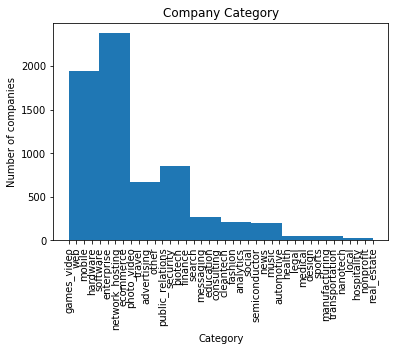

In [13]:
dfba = dfb['category_code']
clean_dfba = [x for x in dfba if str(x) != 'nan']

plt.hist(clean_dfba)
plt.xticks(rotation='vertical')
plt.title('Company Category')
plt.ylabel('Number of companies'), plt.xlabel('Category')
plt.show()